# Testing the CAPM

The purpose of this notebook is to perform a test of the capital asset pricing model (CAPM) in the context of REITs.  There are various versions of the CAPM.  

The Sharpe-Litner version states that: $E(R_i) = R_f + [E(R_M) - R_f] \cdot \beta_{iM}$, 

where we have that $\beta_{iM} = \frac{\text{Cov}(R_i, R_M)}{\sigma^2(R_M)}$.

When we speak of *testing* the CAPM, we mean testing one of three of its implications:

1. expected returns of assets are linearly related to their $\beta$s, and no other variable has marginal explanatory power.

2. $\beta$-premium is positive, meaning that the expected return on the market portfolio exceeds the return on assets who's return is uncorrelated with the market (risk-free lending).

3. The $\beta$-premium is the expected market return minus the risk-free rate.

#### **Using Portfolios**
Performing tests on the CAPM using individual securities can be problematic for a couple of reasons:

1. $\beta$ estimates are noisy for individual securities

2. positive correlations between the residuals of security returns can lead to standard error estimates that are too low

In order to address the noisiness issue (#1) we perform our test on $\beta$-sorted portfolios.  This is valid because the CAPM applies to individual securities as well as portfolios of securities.  We organize our universe of securities into $\beta$-ranked portfolios to have a wide range of betas to work with.  (If we formed randomized portfolios, the range of betas of these portfolios would likely be more compressed than the $\beta$-ranked construction.)

#### **Our Test**

We are actually going to test a time-series version of the CAPM that was originally discussed in Jensen 1998: $R_{it} - R_{ft} = \alpha_i + \beta_{iM}(R_{Mt} - R_{ft}) + \epsilon_t$.

We have price and market-cap data for 100 REITs from 1999-2019, and our test proceeds as follows:

1. Each December, using two years of monthly returns, we estimate the pre-ranking $\beta$ for every REIT against the *market-portfolio*, which we define to be the cap-weight portfolio of all 100 REITs.

1. We form 10 market-cap weighted portfolios based on the deciles of the pre-ranking $\beta$ estimates.

1. We calculate monthly returns for each of the $\beta$-ranked portfolios for the next 12 month.

1. We repeat this process for every year from 2001-2019, which results in 228 monthly returns for each of the $\beta$-ranked portfolios.

1. For each of the $\beta$-ranked portfolios, we calculate its annualized averge return from 2001-2019, and also its realized $\beta$ over the same time period.

1. We then plot these to test for a positive relationship between realized $\beta$ and realzed return.

**SPOILER ALERT:** Our graph looks nothing like the one in Fama-French 2004, but it will be interesting for us to consider why this is the case. 

## Load Packages

Let's begin by loading the packages that we will need.

In [1]:
import pandas as pd 
import numpy as np

## Reading-In Data

Next, let's read in the universe of names that will form our backtest.

In [2]:
df_universe = pd.read_csv('universe.csv')
df_universe = df_universe[['symbol', 'reit_name', 'type', 'sector']]
df_universe.head()

symbol                           reit_name           type    sector
0    ANH  Anworth Mortgage Asset Corporation  Mortgage REIT  Mortgage
1   BXMT     Blackstone Mortgage Trust, Inc.  Mortgage REIT  Mortgage
2    CMO       Capstead Mortgage Corporation  Mortgage REIT  Mortgage
3     DX                 Dynex Capital, Inc.  Mortgage REIT  Mortgage
4    MFA      MFA Mortgage Investments, Inc.  Mortgage REIT  Mortgage

We can also read-in our price data.

In [3]:
df_px_all = pd.read_csv('reit_px.csv')
df_px_all['date'] = pd.to_datetime(df_px_all['date'])
df_px_all.head()

date       open       high        low  close     volume  adjusted  \
0 2004-04-07  20.049999  20.600000  20.049999  20.50  3707500.0  6.464799   
1 2004-04-08  20.500000  20.500000  20.360001  20.43   301200.0  6.442722   
2 2004-04-12  20.450001  20.450001  19.420000  19.52   852900.0  6.155750   
3 2004-04-13  19.510000  19.549999  19.350000  19.51   226800.0  6.152596   
4 2004-04-14  19.400000  19.480000  19.400000  19.43   143900.0  6.127368   

  ticker  
0    ABR  
1    ABR  
2    ABR  
3    ABR  
4    ABR

There is more data in `df_px_all` than we will need, so let's filter this down using various means.

In [4]:
df_px = \
    (
    df_px_all
        .merge(df_universe[['symbol']], right_on = 'symbol', left_on = 'ticker') # limiting to tickers in our universe
        .query('date >= "1998-12-31"') # limiting date range
        .query('date < "2020-01-01"')  # limiting date range
        .assign(year = lambda df: df.date.dt.year) # pulling out year for grouping later
        .assign(month = lambda df: df.date.dt.month) # pulling out month for grouping later
        [['symbol', 'year', 'month', 'date', 'close', 'adjusted']] # keeping only the columns we need
        .sort_values(['symbol', 'year', 'month']) # sorting to make sure our returns calculations are correct
    )
df_px.head()

symbol  year  month       date    close  adjusted
74050    ADC  1998     12 1998-12-31  18.5000  4.091326
74051    ADC  1999      1 1999-01-04  18.2500  4.036036
74052    ADC  1999      1 1999-01-05  17.7500  3.925461
74053    ADC  1999      1 1999-01-06  17.6875  3.911640
74054    ADC  1999      1 1999-01-07  17.7500  3.925461

## Calculating the Monthly Returns for REITs

Most of our calculations will involve monthly returns.  It will be easiest for us to calculate monthly returns from daily returns. Therefore, we will next calculate daily returns for each symbol using a `groupby()`.

In [5]:
df_px['dly_ret'] = df_px.groupby(['symbol'])['adjusted'].pct_change()
df_px.head()

symbol  year  month       date    close  adjusted   dly_ret
74050    ADC  1998     12 1998-12-31  18.5000  4.091326       NaN
74051    ADC  1999      1 1999-01-04  18.2500  4.036036 -0.013514
74052    ADC  1999      1 1999-01-05  17.7500  3.925461 -0.027397
74053    ADC  1999      1 1999-01-06  17.6875  3.911640 -0.003521
74054    ADC  1999      1 1999-01-07  17.7500  3.925461  0.003533

In order to calculate multi-day returns from single day returns, we will need the following user-defined function.

In [6]:
def cum_ret(ret):
    return(np.prod(1 + ret) - 1)

With the `cum_ret()` function created, let's now calculate the monthly returns from the daily returns by again using the `groupby()` function.

In [7]:
df_month_ret = \
    (
    df_px
        .query('year > 1998')
        .groupby(['year', 'month', 'symbol'])[['dly_ret']].agg(cum_ret)
        .reset_index()
        .rename(columns={'dly_ret':'month_ret'})
    )
df_month_ret.head()

year  month symbol  month_ret
0  1999      1    ADC  -0.054054
1  1999      1     AI  -0.019231
2  1999      1    AIV  -0.001681
3  1999      1    AKR  -0.023810
4  1999      1    ALX  -0.078337

## Calculating Monthly Return for Cap-Weighted Market Portfolio

Let's next read-in the market caps that we will use to weight our portfolios.  Notice that for a given month, we use the market-cap from the last day of the previous month. For example, form January 1999, we use the `mkt_cap` (which is simply `cshom` * `close`) from the last business day of December, which was 12/31/1998.

In [8]:
df_mkt_cap = pd.read_csv('market_cap_199901_201912.csv')
df_mkt_cap.head()

symbol  year  month   asof_date      cshom    close  adjusted    mkt_cap
0    ADC  1999      1  1998-12-31  4346000.0  18.5000  4.091326  80.401000
1    ADC  1999      2  1999-01-29  4346000.0  17.5000  3.870174  76.055000
2    ADC  1999      3  1999-02-26  4346000.0  18.7500  4.146615  81.487500
3    ADC  1999      4  1999-03-31  4365000.0  16.1250  3.659280  70.385625
4    ADC  1999      5  1999-04-30  4365000.0  16.9375  3.843661  73.932187

Let's use a `.groupby()` to calculate the total market-cap for the entire REIT universe each month.

In [9]:
df_month_tot_mkt_cap = \
    (
    df_mkt_cap.groupby(['year', 'month'])[['mkt_cap']].sum()
        .reset_index()
        .rename(columns={'mkt_cap':'tot_mkt_cap'})
    )
df_month_tot_mkt_cap.head()

year  month    tot_mkt_cap
0  1999      1  101459.854403
1  1999      2  105091.091280
2  1999      3  102735.918521
3  1999      4  101999.430539
4  1999      5  116221.475620

We now have enough data to calculate the monthly returns of the cap-weighted market portfolio.  There is a lot going on in a few lines of code. If you feel overwhelmed or confused that's normal.  When I write blocks of code like this, and then come back to them a day later, I have a hard time remembering what is going on.  That's why I write lot's of comments for myself.

I encourage you to run each line incrementally to see what is going on.

In [10]:
df_month_mkt_ret = \
    (
    df_month_ret
        .merge(df_mkt_cap, on=['year', 'month', 'symbol']) # appending mkt_cap column
        .merge(df_month_tot_mkt_cap, on=['year', 'month']) # appending tot_mkt_cap column
        .assign(cap_weight = lambda df: df.mkt_cap / df.tot_mkt_cap) # calculating cap_weight
        .assign(weighted_ret = lambda df: df.cap_weight * df.month_ret) # calculating weighted_ret
        .groupby(['year', 'month'])[['weighted_ret']].sum() # calculating weighted average return
        .reset_index()
        .rename(columns={'weighted_ret':'mkt_ret'})
    )
df_month_mkt_ret.head()

year  month   mkt_ret
0  1999      1 -0.011888
1  1999      2 -0.038372
2  1999      3 -0.015660
3  1999      4  0.118465
4  1999      5 -0.022703

## Constructing the Beta-Ranked Portfolios

In order to calculate the pre-ranking $\beta$s, we begin by calculating rolling 24-month correlations between the securities and the market porfolio.  

We are actually calculating many more correlations than we will need. We only need one per year, but we are calculating them for every month.

In [11]:
ser_rolling_corr = \
    (
    df_month_ret
        .merge(df_month_mkt_ret, on=['year', 'month']) # appending market returns column
        .sort_values(['symbol', 'year', 'month']) # sorting because our trailing correlations require it
        .groupby(['symbol'])[['month_ret','mkt_ret']].rolling(25).corr().reset_index() # this results in correlation matrices being calculated
        .query('level_2 == "mkt_ret"') # dropping one of the rows of the correlation matrix
        .drop(columns=['level_1', 'level_2', 'mkt_ret']) # dropping one of the columns of the correlation matrix
        .rename(columns={'month_ret':'corr_24_mo'}) 
        ['corr_24_mo']
    )
ser_rolling_corr.tail() # why did I use .tail() instead of .head() to visually inspect the result?

50895    0.590533
50897    0.588587
50899    0.603470
50901    0.608540
50903    0.608629
Name: corr_24_mo, dtype: float64

Next we calculate rolling 24-month volatilities.

In [12]:
df_vol = \
    (
    df_month_ret
        .merge(df_month_mkt_ret, on=['year', 'month']) # appending market returns
        .sort_values(['symbol', 'year', 'month']) # sorting values because our trailing volatilities require it
        .groupby(['symbol'])[['month_ret','mkt_ret']].rolling(25).std().reset_index() # volatility calculation
        .drop(columns=['level_1']) # removing a useless column
        .rename(columns={'month_ret':'vol_reit', 'mkt_ret':'vol_mkt'})
    )
df_vol.tail()

symbol  vol_reit   vol_mkt
25447     WY  0.087970  0.037352
25448     WY  0.088983  0.037374
25449     WY  0.089011  0.037191
25450     WY  0.088329  0.037487
25451     WY  0.088607  0.037350

We can now calculate the pre-ranking $\beta$s.  We are calculating more than we need, but it makes the coding easier.

In [13]:
df_regression = \
    (
    df_month_ret
        .merge(df_month_mkt_ret, on = ['year', 'month']) # appending market returns
        .sort_values(['symbol', 'year', 'month']) # sorting 
        .assign(corr_24_mo = ser_rolling_corr.values) # appending correlations
        .assign(vol_reit = df_vol['vol_reit'].values) # appending reit vols
        .assign(vol_mkt = df_vol['vol_mkt'].values) # appending market vols
        .assign(beta = lambda df: df.corr_24_mo * (df.vol_reit / df.vol_mkt)) # calculating betas
    )
df_regression.tail() # why am I using .tail() instead of .head() to visually inspect the result

year  month symbol  month_ret   mkt_ret  corr_24_mo  vol_reit  \
25047  2019      8     WY   0.035419  0.035087    0.590533  0.087970   
25148  2019      9     WY   0.066453  0.015848    0.588587  0.088983   
25249  2019     10     WY   0.054513  0.010443    0.603470  0.089011   
25350  2019     11     WY   0.010270 -0.016021    0.608540  0.088329   
25451  2019     12     WY   0.035274  0.006018    0.608629  0.088607   

        vol_mkt      beta  
25047  0.037352  1.390781  
25148  0.037374  1.401373  
25249  0.037191  1.444309  
25350  0.037487  1.433881  
25451  0.037350  1.443889

Let's now rank the REITs by the pre-ranking $\beta$ for each year.

In [14]:
df_beta = \
    (
    df_regression
        .query('year > 2000')
        .query('month == 1')
        .assign(beta_rank = lambda df: df.groupby(['year'])['beta'].rank())
        [['year', 'month', 'symbol', 'beta', 'beta_rank']]
    )
df_beta.head()

year  month symbol      beta  beta_rank
2424  2001      1    ADC  0.461423       36.0
3636  2002      1    ADC  0.078526       15.0
4848  2003      1    ADC  0.280288       26.0
6060  2004      1    ADC  0.888451       70.0
7272  2005      1    ADC  1.099805       93.0

Here is a quick test to see that the ranking worked properly: I sort by `beta` to make sure that the `beta_rank` looks correct.

In [15]:
df_beta.sort_values(['year', 'beta'], ascending=True).head()

year  month symbol      beta  beta_rank
2450  2001      1     DX -1.492934        1.0
2443  2001      1   CMCT -0.301825        2.0
2470  2001      1   IRET -0.213631        3.0
2469  2001      1    IOR -0.203502        4.0
2511  2001      1    TCI -0.195403        5.0

To group the REITs into `beta_rank` deciles, we will use the following custom function.

In [16]:
def rank_group(rank):
    if rank <= 10:
        return(1)
    elif 11 <= rank <= 20:
        return(2)
    elif 21 <= rank <= 30:
        return(3)
    elif 31 <= rank <= 40:
        return(4)
    elif 41 <= rank <= 50:
        return(5)
    elif 51 <= rank <= 60:
        return(6)
    elif 61 <= rank <= 70:
        return(7)
    elif 71 <= rank <= 80:
        return(8)
    elif 81 <= rank <= 90:
        return(9)
    elif 91 <= rank <= 100:
        return(10)

We use the `.apply()` along with our custom function `rank_group()` to create groupings.

In [17]:
df_beta['beta_portfolio'] = df_beta['beta_rank'].apply(rank_group)
df_beta.head()

year  month symbol      beta  beta_rank  beta_portfolio
2424  2001      1    ADC  0.461423       36.0             4.0
3636  2002      1    ADC  0.078526       15.0             2.0
4848  2003      1    ADC  0.280288       26.0             3.0
6060  2004      1    ADC  0.888451       70.0             7.0
7272  2005      1    ADC  1.099805       93.0            10.0

And here a is a quick visual test that the grouping worked.

In [18]:
df_beta.sort_values(['year', 'beta']).head()

year  month symbol      beta  beta_rank  beta_portfolio
2450  2001      1     DX -1.492934        1.0             1.0
2443  2001      1   CMCT -0.301825        2.0             1.0
2470  2001      1   IRET -0.213631        3.0             1.0
2469  2001      1    IOR -0.203502        4.0             1.0
2511  2001      1    TCI -0.195403        5.0             1.0

Let's now calculate the total market-cap of the $\beta$-ranked portfolios at the beginning of each year.

In [19]:
# total market cap of REITs in each portfolio, at the beginning of each year
df_tot_mkt_cap_port = \
    (
    df_beta
        .merge(df_mkt_cap[['symbol', 'year', 'month', 'mkt_cap']], on=['symbol', 'year', 'month'])
        .groupby(['year', 'beta_portfolio'])['mkt_cap'].sum().reset_index()
        .rename(columns={'mkt_cap':'tot_mkt_cap_port'})
    )
df_tot_mkt_cap_port.head()

year  beta_portfolio  tot_mkt_cap_port
0  2001             1.0       2530.600010
1  2001             2.0        740.157250
2  2001             3.0       5588.672923
3  2001             4.0      10403.310804
4  2001             5.0      11580.123002

Next, we calculate the weights of each of the REITs in their $\beta$-ranked portfolios.  These weights will be based on market-cap.

In [20]:
# portfolio weightings of all the beta-ranked portfolios
df_port_mkt_cap_weights = \
    (
    df_beta
        .merge(df_mkt_cap[['symbol', 'year', 'month', 'mkt_cap']], on=['symbol', 'year', 'month'])
        .merge(df_tot_mkt_cap_port, on=['year', 'beta_portfolio'])
        .assign(weight_mkt_cap = lambda df: df.mkt_cap / df.tot_mkt_cap_port)
        [['year', 'beta_portfolio', 'symbol', 'weight_mkt_cap']]
    )
df_port_mkt_cap_weights.sort_values(['year', 'beta_portfolio']).head()

year  beta_portfolio symbol  weight_mkt_cap
1642  2001             1.0    CTO        0.026649
1643  2001             1.0     DX        0.013569
1644  2001             1.0  FREVS        0.005394
1645  2001             1.0   GYRO        0.074469
1646  2001             1.0    IOR        0.001629

This concludes the construction of the $\beta$-ranked portfolios.

## Calculating Realized Betas and Returns of the Beta-Ranked Portfolios

Now that the $\beta$-weighted portfolios have been constructed, we can now calculated the realized betas and returns of the portfolio.  Let's begin with former.  

As a first step we calculate the realized correlations.

In [21]:
df_corr_realized = \
    (
    df_port_mkt_cap_weights
        .merge(df_month_ret, on = ['year', 'symbol']) # appending monthly returns of individual REITs
        .assign(month_ret_weighted = lambda df: df.weight_mkt_cap * df.month_ret) # weighted returns of individual REITs
        .groupby(['beta_portfolio', 'year', 'month'])[['month_ret_weighted']].sum().reset_index() # weighted returns beta_portfolios
        .merge(df_month_mkt_ret, on = ['year', 'month']) # appending monthly returns of market portfolio
        .groupby(['beta_portfolio'])[['month_ret_weighted', 'mkt_ret']].corr().reset_index() # correlation matrices
        .query('level_1 == "mkt_ret"') # removing unneeded row of correlation matrix
        .drop(columns = ['level_1', 'mkt_ret']) # removing unneeded column of correlation matrix
        .rename(columns = {'month_ret_weighted':'corr_mkt'})
    )
df_corr_realized

beta_portfolio  corr_mkt
1              1.0  0.607471
3              2.0  0.607747
5              3.0  0.773779
7              4.0  0.870923
9              5.0  0.886251
11             6.0  0.932003
13             7.0  0.925731
15             8.0  0.928689
17             9.0  0.898763
19            10.0  0.873374

Next, we calculate realized standard deviations of the monthly returns of the beta ranked portfolios and the market portfolio.

In [22]:
df_vol_realized = \
    (
    df_port_mkt_cap_weights
        .merge(df_month_ret, on = ['year', 'symbol']) # appending monthly returns of individual REITs
        .assign(month_ret_weighted = lambda df: df.weight_mkt_cap * df.month_ret) # calculating weighted monthly returns of REITs
        .groupby(['beta_portfolio', 'year', 'month'])[['month_ret_weighted']].sum().reset_index() # calculating beta-ranked portfolio returns
        .merge(df_month_mkt_ret, on = ['year', 'month']) # appending monthly market returns
        .groupby(['beta_portfolio'])[['month_ret_weighted', 'mkt_ret']].std().reset_index() # standard deviations
        .rename(columns = {'month_ret_weighted':'vol_port', 'mkt_ret':'vol_mkt'})
    )
df_vol_realized

beta_portfolio  vol_port   vol_mkt
0             1.0  0.049982  0.055166
1             2.0  0.045970  0.055166
2             3.0  0.051988  0.055166
3             4.0  0.055307  0.055166
4             5.0  0.063659  0.055166
5             6.0  0.059069  0.055166
6             7.0  0.063633  0.055166
7             8.0  0.067985  0.055166
8             9.0  0.070935  0.055166
9            10.0  0.097544  0.055166

Now that we have realized correlations and standard deviations, we have everything that we need to calculate the realized betas of the beta-ranked portfolios.

In [23]:
# realized beta of beta-ranked portfolios
df_beta_realized = \
    (
    df_corr_realized
        .merge(df_vol_realized, on = 'beta_portfolio')
        .assign(beta_realized = lambda df: df.corr_mkt * (df.vol_port / df.vol_mkt))
    )
df_beta_realized

beta_portfolio  corr_mkt  vol_port   vol_mkt  beta_realized
0             1.0  0.607471  0.049982  0.055166       0.550387
1             2.0  0.607747  0.045970  0.055166       0.506443
2             3.0  0.773779  0.051988  0.055166       0.729203
3             4.0  0.870923  0.055307  0.055166       0.873146
4             5.0  0.886251  0.063659  0.055166       1.022689
5             6.0  0.932003  0.059069  0.055166       0.997945
6             7.0  0.925731  0.063633  0.055166       1.067819
7             8.0  0.928689  0.067985  0.055166       1.144485
8             9.0  0.898763  0.070935  0.055166       1.155670
9            10.0  0.873374  0.097544  0.055166       1.544293

The next block of code calculated the realized returns for the beta-ranked portfolios and the market portfolio.

In [24]:
df_ret_realized = \
    (
    df_port_mkt_cap_weights
        .merge(df_month_ret, on = ['year', 'symbol']) # appending monthly returns of individual REITs
        .assign(month_ret_weighted = lambda df: df.weight_mkt_cap * df.month_ret) # calculating the weighted return for REITs in portfolio
        .groupby(['beta_portfolio', 'year', 'month'])[['month_ret_weighted']].sum().reset_index() # calculating the beta-ranked portfolios of the REITs
        .merge(df_month_mkt_ret, on = ['year', 'month']) # appending market portfolio returns
        .sort_values(['beta_portfolio', 'year', 'month']) 
        .groupby(['beta_portfolio'])[['month_ret_weighted', 'mkt_ret']].agg(cum_ret).reset_index() # calculating cumulative retunrs
        .assign(avg_ret_port = lambda df: ((1 + df.month_ret_weighted) ** (1 / 19)) - 1) # annualize portfolio returns
        .assign(avg_ret_mkt = lambda df: ((1 + df.mkt_ret) ** (1 / 19)) - 1) # annualized market returns
    )
df_ret_realized

beta_portfolio  month_ret_weighted  mkt_ret  avg_ret_port  avg_ret_mkt
0             1.0            2.548919  4.00265      0.068938     0.088429
1             2.0           10.199956  4.00265      0.135591     0.088429
2             3.0            9.391882  4.00265      0.131124     0.088429
3             4.0            4.757517  4.00265      0.096509     0.088429
4             5.0            4.131452  4.00265      0.089886     0.088429
5             6.0            6.250839  4.00265      0.109899     0.088429
6             7.0            4.394818  4.00265      0.092761     0.088429
7             8.0            3.186710  4.00265      0.078277     0.088429
8             9.0            4.501466  4.00265      0.093887     0.088429
9            10.0            1.723129  4.00265      0.054140     0.088429

Let's join together the realzed betas and the realized returns so that we can graph them.

In [25]:
df_graph = df_beta_realized.merge(df_ret_realized, on = 'beta_portfolio')
df_graph[['beta_portfolio', 'beta_realized', 'avg_ret_port']]

beta_portfolio  beta_realized  avg_ret_port
0             1.0       0.550387      0.068938
1             2.0       0.506443      0.135591
2             3.0       0.729203      0.131124
3             4.0       0.873146      0.096509
4             5.0       1.022689      0.089886
5             6.0       0.997945      0.109899
6             7.0       1.067819      0.092761
7             8.0       1.144485      0.078277
8             9.0       1.155670      0.093887
9            10.0       1.544293      0.054140

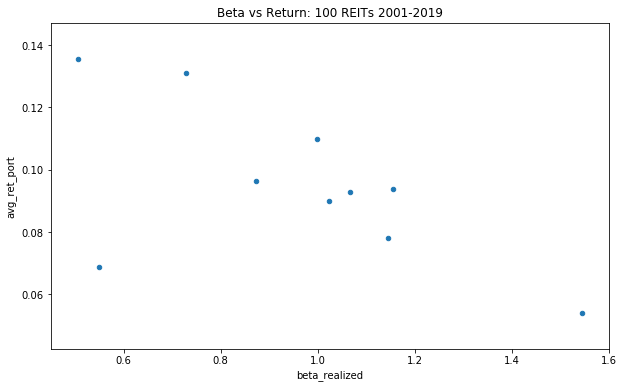

In [26]:
(
df_graph
    .plot.scatter(
        x = 'beta_realized', 
        y = 'avg_ret_port',
        title = 'Beta vs Return: 100 REITs 2001-2019',
        figsize = (10, 6)
    )
);

## Discussion Questions

1. Does the relationship look positive or negative?

2. What might explain the differences between our graph and the one in Figure 2 (pg 33) of Fama and French 2004.

## References

"The Capital Asset Pricing Model: Theory and Evidence" - 2004 - Eugene Fama and Kenneth French, *Journal of Economic Perspectives*

"The Performace of Mutual Funds in the Period 1945-1964" - 1968 - Michael C. Jensen, *Journal of Finance*.